# **Cross-wavelet coherence analysis**

### **Import libraries & load data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sys import path
from __future__ import division
from matplotlib import pyplot
from scipy.interpolate import interp1d
import pycwt as wavelet
from pycwt.helpers import find
import flirt

/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/flirt/acc/feature_calculation.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
data_dir = '../data/preprocessed/'
mindware_dir = '../data/mindware_processed/'

In [3]:
condition_no = 3
person_1 = 'NN'
person_2 = 'YW'
ecg_p1 = []
ecg_p2 = []
mw_p1 = []
mw_p2 = []
for condition_no in [1, 2, 3]:
    ecg_p1.append(pd.read_csv(f'{data_dir}preprocessed_{person_1}_{condition_no}.csv'))
    ecg_p2.append(pd.read_csv(f'{data_dir}preprocessed_{person_2}_{condition_no}.csv'))
    mw_p1.append(pd.read_csv(f'{mindware_dir}mindware_IBI_{person_1}_{condition_no}.csv'))
    mw_p2.append(pd.read_csv(f'{mindware_dir}mindware_IBI_{person_2}_{condition_no}.csv'))

## **IBI analysis**

### **Basic visualization**

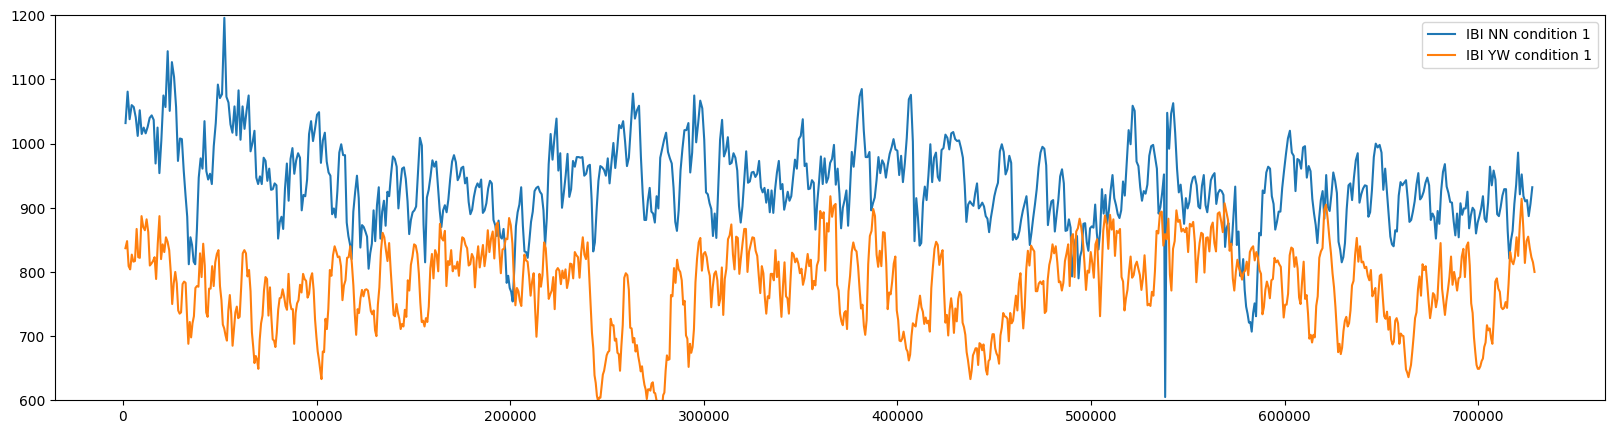

In [4]:
condition_no = 1
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(mw_p1[condition_no]['time'], mw_p1[condition_no]['IBI'], label=f'IBI {person_1} condition {condition_no}')
ax.plot(mw_p2[condition_no]['time'], mw_p2[condition_no]['IBI'], label=f'IBI {person_2} condition {condition_no}')
ax.set_ylim(600, 1200)
ax.legend()
plt.show()

### **Wavelet basics**

#### **Continuous vs discrete wavelet transform**

Continuous wavelet transform compares a signal with shifted and scaled (contracted or streched) copies of a basic wavelet. If $\psi(t)$ is a wavelet centered at $t=0$ with time support on $[-T/2, T/2]$, then $\frac{1}{s}\psi(\frac{t-u}{s})$ is centered at $t=u$ with time support $[-\frac{sT}{2}+u, \frac{sT}{2}+u]$. $s$ is a scaling factor; when $s>1$, the wavelet is streched (slow changes), and when $0<s<1$, the wavelet is contracted (fast changes). 

The major difference between continuous wavelet transform and discrete wavelet transform is that how the scale parameter ($s$) is discretized. continuous wavelet transform discretizes scale more finely than the discrete wavelet transform.

> Reference: https://www.mathworks.com/help/wavelet/gs/continuous-and-discrete-wavelet-transforms.html

In [5]:
# Convert to numpy arrays
ibi_array_p1 = [mw_p1[condition_no]['IBI'].values for condition_no in [0, 1, 2]]
ibi_array_p2 = [mw_p2[condition_no]['IBI'].values for condition_no in [0, 1, 2]]

time_array_p1 = [mw_p1[condition_no]['time'].values for condition_no in [0, 1, 2]]
time_array_p2 = [mw_p2[condition_no]['time'].values for condition_no in [0, 1, 2]]

### Re-sampling

Because the wavelet analyis requires arrays with a fixed sampling rate, re-sampling the IBI arrays.

In [6]:
# Re-samplg at 1 Hz
new_t = [np.arange(max(time_array_p1[condition_no][0], time_array_p2[condition_no][0]), min(time_array_p1[condition_no][-1], time_array_p2[condition_no][-1]), 1000) for condition_no in [0, 1, 2]]
resampled_ibi_p1 = []
resampled_ibi_p2 = []
for condition_no in [0, 1, 2]:
    interp_func_p1 =interp1d(time_array_p1[condition_no], ibi_array_p1[condition_no], kind='quadratic')
    resampled_ibi_p1.append(interp_func_p1(new_t[condition_no]))
    interp_func_p2 = interp1d(time_array_p2[condition_no], ibi_array_p2[condition_no], kind='quadratic')
    resampled_ibi_p2.append(interp_func_p2(new_t[condition_no]))

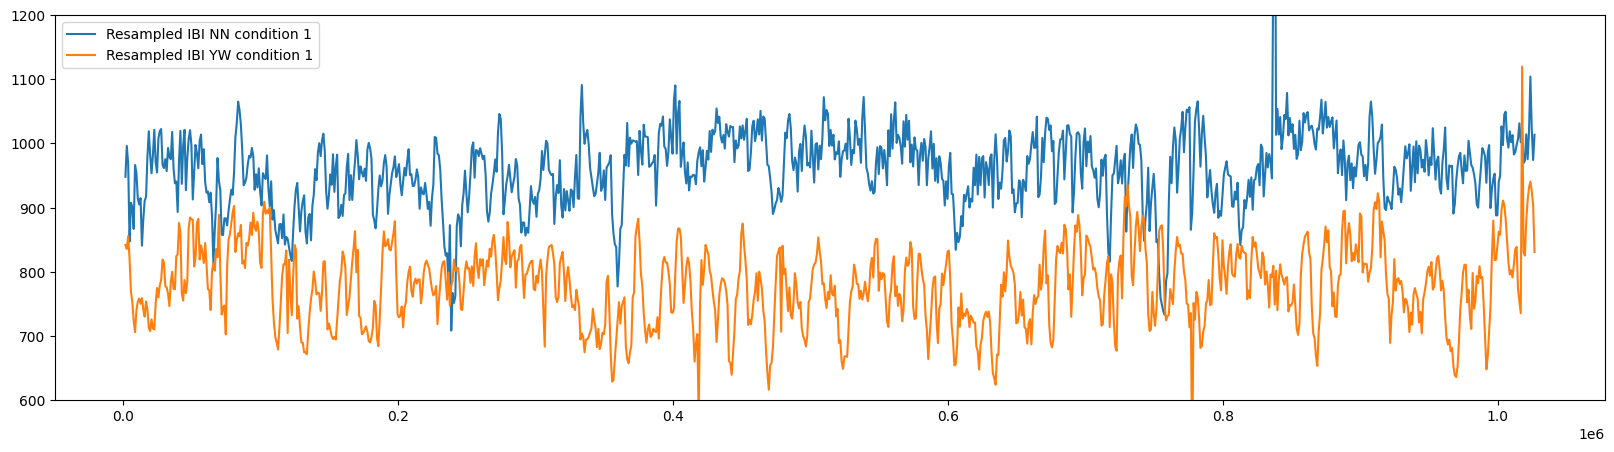

In [7]:
condition_no = 0
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t[condition_no], resampled_ibi_p1[condition_no], label=f'Resampled IBI {person_1} condition {condition_no + 1}')
ax.plot(new_t[condition_no], resampled_ibi_p2[condition_no], label=f'Resampled IBI {person_2} condition {condition_no + 1}')
ax.set_ylim(600, 1200)
ax.legend()
plt.show()

### Standardization

Before applying the wavelet analysis, subtract a mean value and normalize by standard deviation.

In [8]:
ibi_standardized_p1 = [(resampled_ibi_p1 - np.mean(resampled_ibi_p1)) / np.std(resampled_ibi_p1) for resampled_ibi_p1 in resampled_ibi_p1]
ibi_standardized_p2 = [(resampled_ibi_p2 - np.mean(resampled_ibi_p2)) / np.std(resampled_ibi_p2) for resampled_ibi_p2 in resampled_ibi_p2]

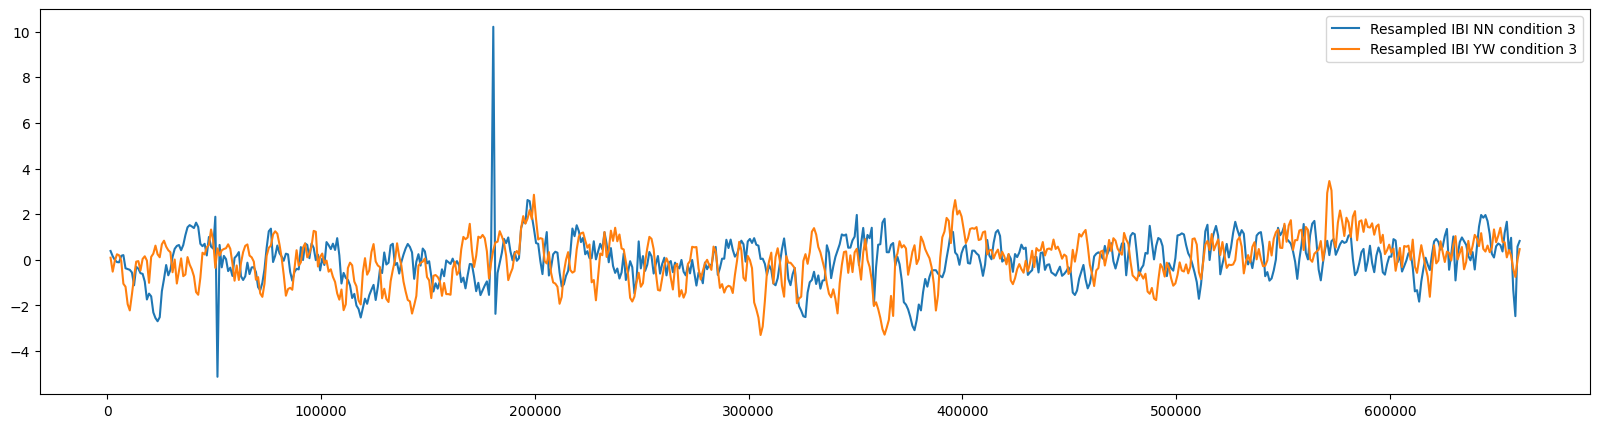

In [9]:
condition_no = 2
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t[condition_no], ibi_standardized_p1[condition_no], label=f'Resampled IBI {person_1} condition {condition_no + 1}')
ax.plot(new_t[condition_no], ibi_standardized_p2[condition_no], label=f'Resampled IBI {person_2} condition {condition_no + 1}')
ax.legend()
plt.show()

### Decide parameters for wavelet analysis

#### Choose a type of Wavelet
**Morlet wavelet**: Has high frequency resolution

**Paul wavelet**:

**Derivative of a Gaussian wavelet family**:

**Mexican hat wavelet**:


> Refefence:Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. Bulletin of the American Meteorological Society, 79(1), 61–78.

In [10]:
fs = 1
N = len(new_t)
dt = 1/fs
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 seconds = 0.5 seconds
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves

### Continuous wavelet transform

`cwt(signal, dt, dj=1 / 12, s0=-1, J=-1, wavelet='morlet', freqs=None)`

This function implements continuous wavelet transform.

**Parameters**

- `signal`: Signal to implement wavelet transform.
- `dt`: Sampling interval of the signal.
- `dj`: Spacing between discrete value. Smaller value results in higher resolution but slower calculation.
- `s0`: Smallest scale of the wavelet. By default, 2 * dt.
- `J`: Number of scales. Scales range from s0 up to s0 * 2*(J * dj), which gives a total of (J + 1) scales. 
- `wavelet`: Instance of wavelet class or string mother wavelet class.
- `freqs`: Custom frequencies to use instead of the scales provided.

**Returns**
- `W`: Wavelet transform results. Has (J+1) * N dimensions.
- `freqs`: Vector of Fourier frequencies (in 1 / time units) that corresponds to the wavelet scales.
- `coi`: Returns the cone of influence, which is a vector of N points containing the maximum Fourier period of useful information at that particular time.
- `fft`: Normalized fast Fourier transform of the input signal. 
- `fftfreq`: Fourier frequencies (in 1/time units) for the calculated FFT spectrum.

#### Double-check if wavelet coherence between two same signals will be 1

In [11]:
wct_auto, awct_auto, coi_auto, freq_auto, sig_auto = wavelet.wct(ibi_standardized_p1[condition_no], ibi_standardized_p1[condition_no], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=False)

NOTE: WCT significance loaded from cache.



/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


In [12]:
print("Max:", np.max(wct_auto))
print("Min:", np.min(wct_auto))
print("Mean:", np.mean(wct_auto))

Max: 1.0000000000000373
Min: 0.9999999999999482
Mean: 1.0


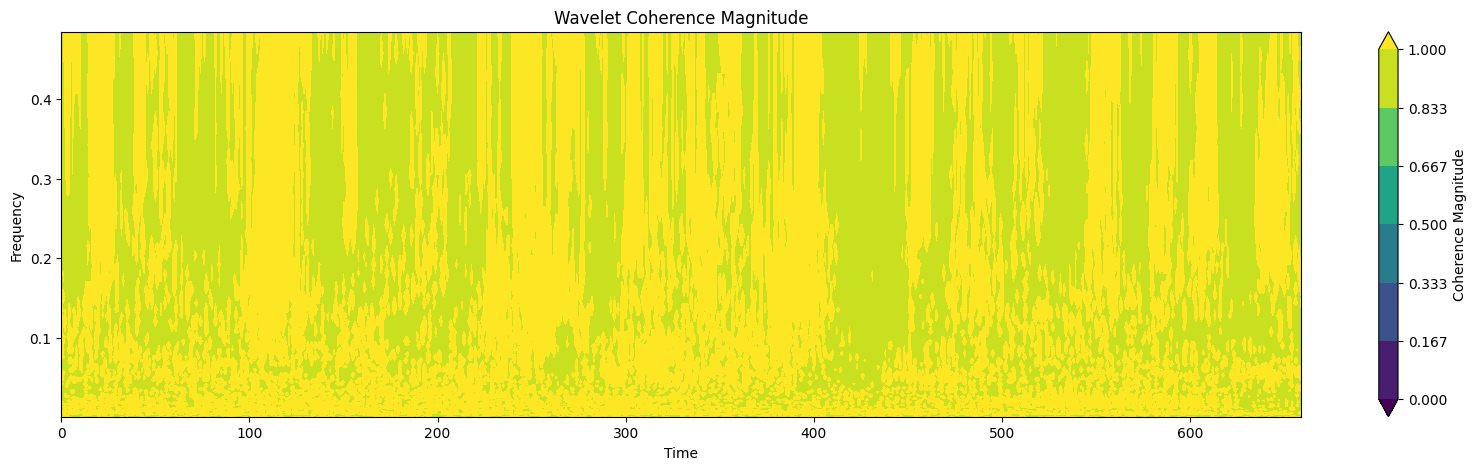

In [13]:
plt.figure(figsize=(20, 5))
plt.contourf(np.arange(len(ibi_standardized_p1[condition_no])) * dt, freq_auto, wct_auto, levels=np.linspace(0, 1, 7), extend='both')
plt.title('Wavelet Coherence Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Coherence Magnitude')
plt.show()

### Use surrogate data to determine threshold

In [14]:
wct_surrogate = []
max_idx = min(len(ibi_standardized_p1[0]), len(ibi_standardized_p2[1]))
wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_p1[0][:max_idx], ibi_standardized_p2[1][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(ibi_standardized_p1[0]), len(ibi_standardized_p2[2]))
wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_p1[0][:max_idx], ibi_standardized_p2[2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(ibi_standardized_p1[1]), len(ibi_standardized_p2[0]))
wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_p1[1][:max_idx], ibi_standardized_p2[0][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(ibi_standardized_p1[1]), len(ibi_standardized_p2[2]))
wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_p1[1][:max_idx], ibi_standardized_p2[2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(ibi_standardized_p1[2]), len(ibi_standardized_p2[0]))
wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_p1[2][:max_idx], ibi_standardized_p2[0][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(ibi_standardized_p1[2]), len(ibi_standardized_p2[1]))
wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_p1[2][:max_idx], ibi_standardized_p2[1][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.



95th percentile: 0.8207334431238908


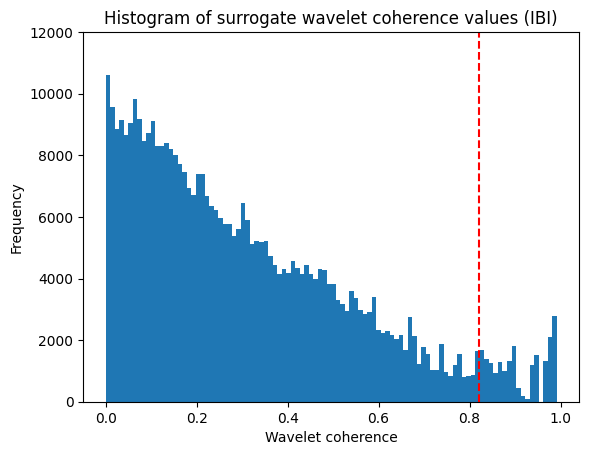

In [15]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
percentile_95 = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (IBI)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
plt.ylim(0, 12000)
plt.show()

### Calculating wavelet coherence between two signals

In [16]:
condition_no = 2
wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[condition_no], ibi_standardized_p2[condition_no], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)

NOTE: WCT significance loaded from cache.



In [ ]:
def plot_wavelet_result(p1_series, threshold, wct, awct, coi, freq, modality, ylim_low=None, ylim_high=None):
    # 周波数を周期に変換
    period = 1 / freq  # 周波数を逆数にすることで周期を取得
    coi = 1 / coi  # COI も周期に変換

    fig, ax = plt.subplots(figsize=(10, 5))

    # カラーマップのプロット
    contour = ax.contourf(
        np.arange(len(p1_series)) * dt,
        period,  # 周期を y 軸に使用
        wct,
        levels=np.linspace(0, 1, 7)
    )

    # ベクトル成分計算
    u = np.cos(awct) * wct  # x成分
    v = np.sin(awct) * wct  # y成分

    # 時間-周期グリッドの作成
    X, Y = np.meshgrid(np.arange(len(p1_series)) * dt, period)

    # 有意性マスクの作成
    significant_mask = wct > threshold

    # 矢印の間引き
    step = 5
    ax.quiver(
        X[significant_mask][::step],
        Y[significant_mask][::step],
        u[significant_mask][::step],
        v[significant_mask][::step],
        scale=100,
        color='black'
    )

    # COI をプロット（周期に変換したものを使用）
    coi_time = np.arange(len(p1_series)) * dt
    coi_period = 1 / coi  # COI も周期に変換
    ax.plot(coi_time, coi_period, 'k--', label='Cone of Influence')

    # カラーバーの追加
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Coherence Magnitude')

    # 軸ラベル、タイトル、範囲設定
    ax.set_title(f'Wavelet Coherence Magnitude with Phase Arrows ({modality})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Period (time units)')
    if ylim_low is not None and ylim_high is not None:
        ax.set_ylim(ylim_low, ylim_high)  # 周期の範囲に合わせる

    # 凡例を追加
    ax.legend()

    plt.show()

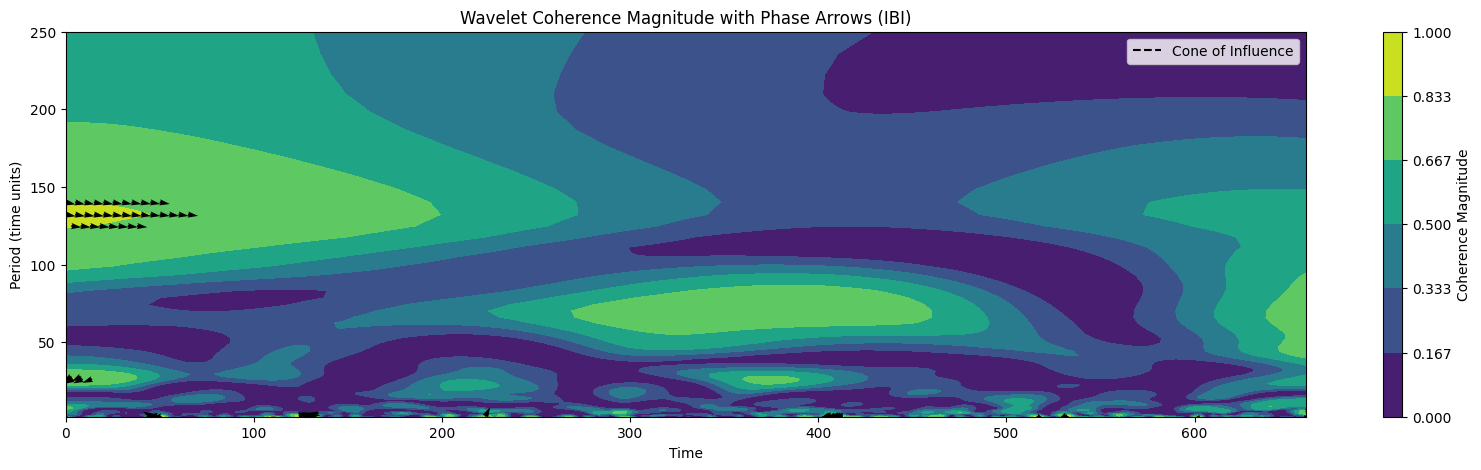

In [377]:
plot_wavelet_result(p1_series=ibi_standardized_p1[condition_no], threshold=percentile_95, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=2, ylim_high=250)

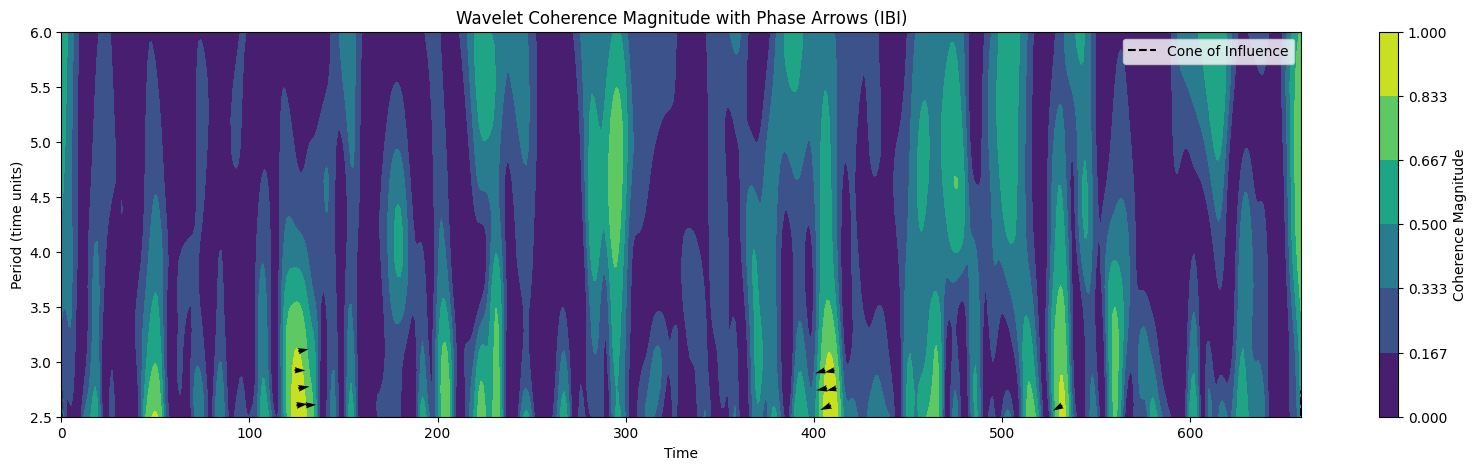

In [379]:
plot_wavelet_result(p1_series=ibi_standardized_p1[condition_no], threshold=percentile_95, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=2.5, ylim_high=6)

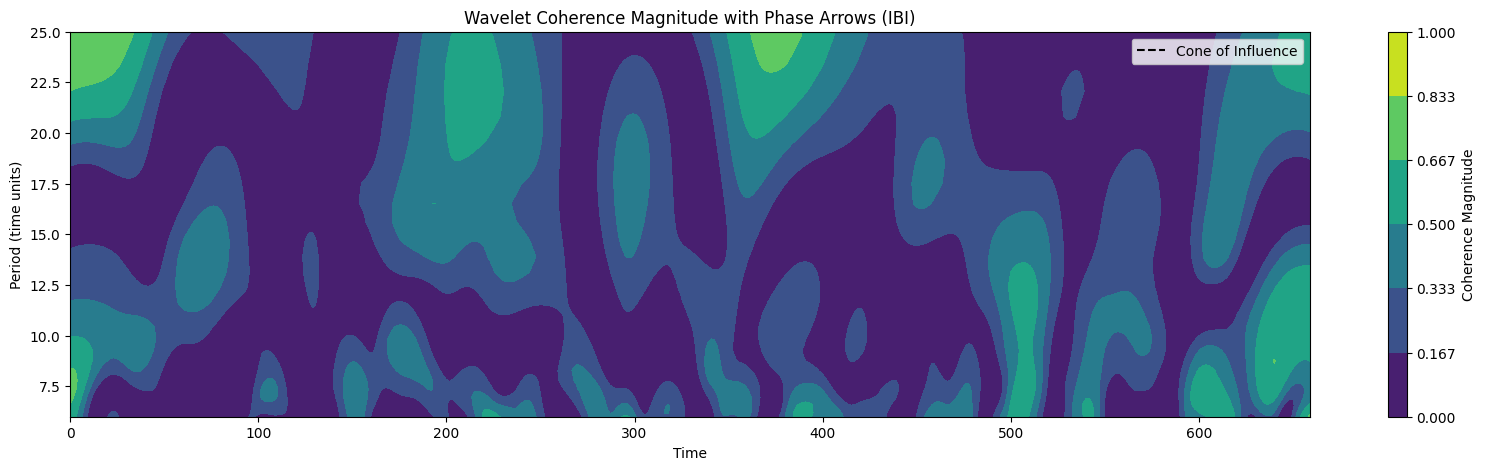

In [380]:
plot_wavelet_result(p1_series=ibi_standardized_p1[condition_no], threshold=percentile_95, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=6, ylim_high=25)

## **HRV analysis**

### Calculate second-by-second RMSSD

In [328]:
start_time = '2024-01-01 00:00:00'
datetime_array_p1 = [pd.to_datetime(start_time) + pd.to_timedelta(time_array_p1[condition_no], unit='ms') for condition_no in [0, 1, 2]]
datetime_array_p2 = [pd.to_datetime(start_time) + pd.to_timedelta(time_array_p2[condition_no], unit='ms') for condition_no in [0, 1, 2]]

In [329]:
ibi_dfs_p1 = [
    pd.DataFrame({
        'datetime': datetime_array_p1[condition_no],
        'IBI': ibi_array_p1[condition_no]
    }).set_index('datetime')
    for condition_no in [0, 1, 2]
]
ibi_dfs_p2 = [
    pd.DataFrame({
        'datetime': datetime_array_p2[condition_no],
        'IBI': ibi_array_p2[condition_no]
    }).set_index('datetime')
    for condition_no in [0, 1, 2]
]

In [333]:
hrv_p1 = [flirt.get_hrv_features(ibi_dfs_p1[condition_no]['IBI'], window_length=30, window_step_size=1, domains=['td'], clean_data=True) for condition_no in [0, 1, 2]]
hrv_p2= [flirt.get_hrv_features(ibi_dfs_p2[condition_no]['IBI'], window_length=30, window_step_size=1, domains=['td'], clean_data=True) for condition_no in [0, 1, 2]]

HRV features: 100%|██████████| 633/633 [00:00<00:00, 11511.37it/s]


In [349]:
rmssd_concat = [pd.merge(hrv_p1[condition_no]['hrv_rmssd'], hrv_p2[condition_no]['hrv_rmssd'], on='datetime', how='inner', suffixes=('_p1', '_p2')) for condition_no in [0, 1, 2]] 

In [351]:
for condition_no in [0, 1, 2]:
    df = rmssd_concat[condition_no].reset_index()
    df['time'] = (df['datetime'] - pd.to_datetime(start_time)).dt.total_seconds()
    df = df.drop(columns=['datetime'])
    rmssd_concat[condition_no] = df

In [352]:
rmssd_concat[0]

,hrv_rmssd_p1,hrv_rmssd_p2,time
0,50.108216,21.944307,31.0
1,48.582155,21.920910,32.0
2,48.947635,21.492396,33.0
3,44.407207,21.429670,34.0
4,44.101057,21.298248,35.0
...,...,...,...
993,38.375639,36.498716,1024.0
994,39.554851,34.838589,1025.0
995,45.711992,33.442114,1026.0
996,45.748186,33.787942,1027.0


### Standardize HRV

In [355]:
standardized_rmssd = []
for condition_no in [0, 1, 2]:
    df = rmssd_concat[condition_no].copy()
    df['hrv_rmssd_p1'] = (df['hrv_rmssd_p1'] - np.mean(df['hrv_rmssd_p1'])) / np.std(df['hrv_rmssd_p1'])
    df['hrv_rmssd_p2'] = (df['hrv_rmssd_p2'] - np.mean(df['hrv_rmssd_p2'])) / np.std(df['hrv_rmssd_p2'])
    standardized_rmssd.append(df)

### Surrogate analysis

In [358]:
wct_surrogate = []
max_idx = min(len(standardized_rmssd[0]), len(standardized_rmssd[1]))
wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd[0]['hrv_rmssd_p1'][:max_idx], standardized_rmssd[1]['hrv_rmssd_p2'][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(standardized_rmssd[0]), len(standardized_rmssd[2]))
wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd[0]['hrv_rmssd_p1'][:max_idx], standardized_rmssd[2]['hrv_rmssd_p2'][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(standardized_rmssd[1]), len(standardized_rmssd[0]))
wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd[1]['hrv_rmssd_p1'][:max_idx], standardized_rmssd[0]['hrv_rmssd_p2'][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(standardized_rmssd[1]), len(standardized_rmssd[2]))
wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd[1]['hrv_rmssd_p1'][:max_idx], standardized_rmssd[2]['hrv_rmssd_p2'][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(standardized_rmssd[2]), len(standardized_rmssd[0]))
wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd[2]['hrv_rmssd_p1'][:max_idx], standardized_rmssd[0]['hrv_rmssd_p2'][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)
max_idx = min(len(standardized_rmssd[2]), len(standardized_rmssd[1]))
wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd[2]['hrv_rmssd_p1'][:max_idx], standardized_rmssd[1]['hrv_rmssd_p2'][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
wct_surrogate.append(wct)

/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


Calculating wavelet coherence significance


100%|██████████| 300/300 [09:22<00:00,  1.88s/it]

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.



95th percentile: 0.7292762658629866


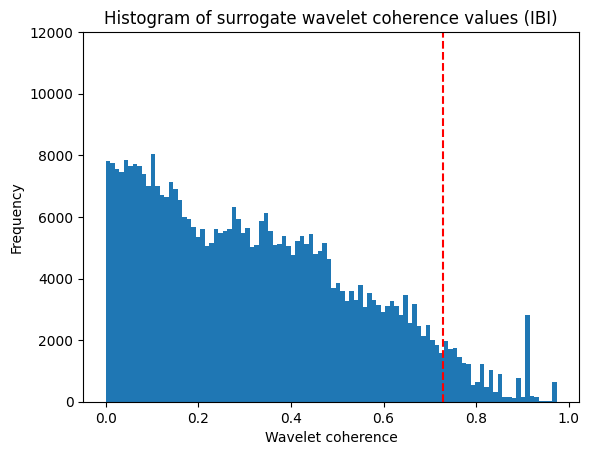

In [368]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
percentile_95_hrv = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95_hrv)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (IBI)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
plt.ylim(0, 12000)
plt.show()

### Cross wavelet transform

In [389]:
condition_no = 2
wct_rmssd, awct_rmssd, coi_rmssd, freq_rmssd, sig_rmssd = wavelet.wct(standardized_rmssd[condition_no]['hrv_rmssd_p1'], standardized_rmssd[condition_no]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)

NOTE: WCT significance loaded from cache.



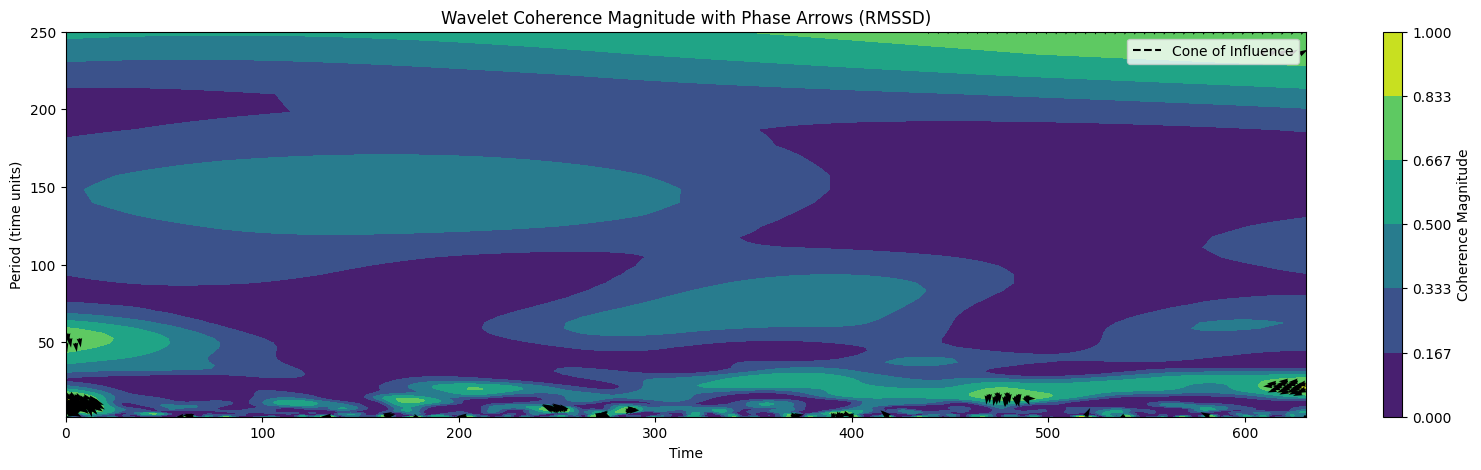

In [390]:
plot_wavelet_result(p1_series=standardized_rmssd[condition_no]['hrv_rmssd_p1'], threshold=percentile_95_hrv, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=2, ylim_high=250)

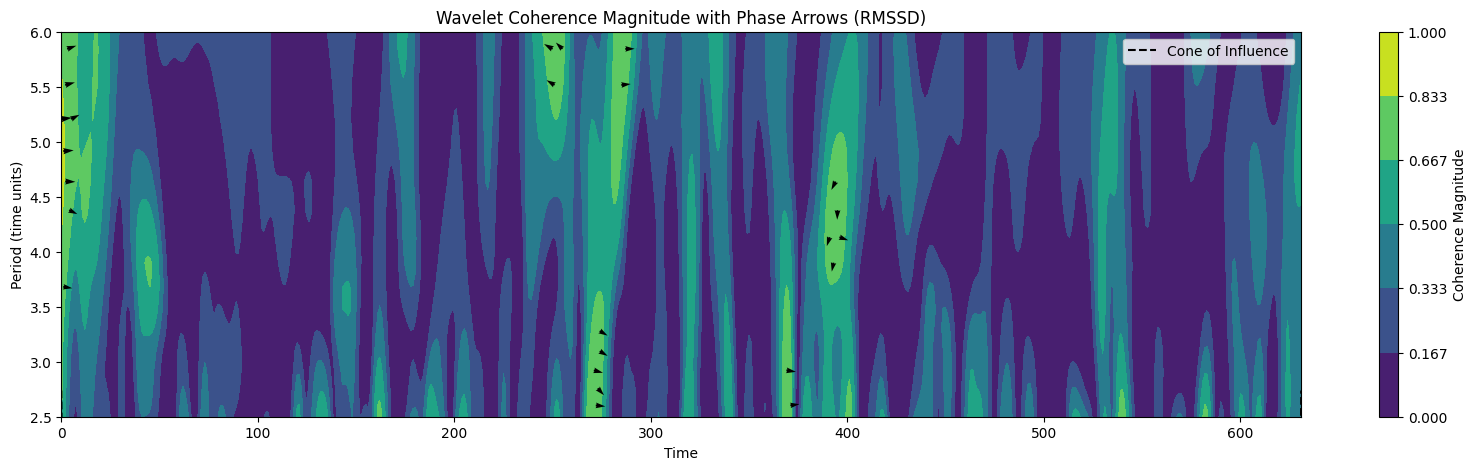

In [391]:
plot_wavelet_result(p1_series=standardized_rmssd[condition_no]['hrv_rmssd_p1'], threshold=percentile_95_hrv, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=2.5, ylim_high=6)

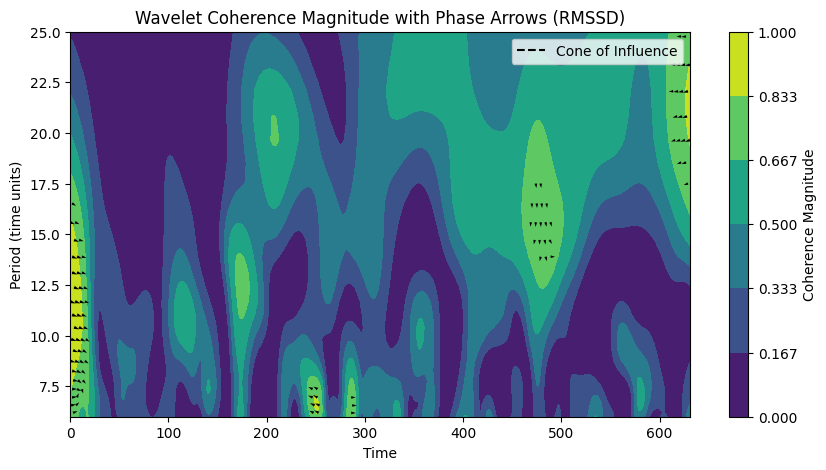

In [396]:
plot_wavelet_result(p1_series=standardized_rmssd[condition_no]['hrv_rmssd_p1'], threshold=percentile_95_hrv, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=6, ylim_high=25)